#### Mahri
I will use dicom images because they preserve accurate pixel spacing and temporal ordering that might be needed for ejection fraction and motion tracking.

In [47]:
import pandas as pd
from config import *
import os
import numpy as np
from skimage import exposure, filters, measure, morphology
import matplotlib.pyplot as plt
import pydicom
from skimage import img_as_ubyte
from skimage.feature import canny
from skimage.measure import label, regionprops

Read the excel file with patient filepaths to start processing

In [3]:
patient_xlsx = patient_data_excel_path
patient_data_df = pd.read_excel(patient_xlsx, sheet_name=patient_data)
patient_filepaths_df = pd.read_excel(patient_xlsx, sheet_name=patient_filepaths)

display(patient_data_df.head(2))
display(patient_filepaths_df.head(2))

,patient_id,original_id,gender,age,pathology,filepath,gif_filepath
0,SCD0000101,SC-HF-I-1,Male,53,Heart failure with infarct,SCD_IMAGES_01\SCD0000101\CINESAX_300,SCD_IMAGES_01\SCD0000101\SCD0000101_gif.gif
1,SCD0000201,SC-HF-I-2,Male,48,Heart failure with infarct,SCD_IMAGES_01\SCD0000201\CINESAX_300,SCD_IMAGES_01\SCD0000201\SCD0000201_gif.gif


,patient_id,dcm_image_filepath
0,SCD0000101,SCD_IMAGES_01\SCD0000101\CINESAX_300\IM-0003-0...
1,SCD0000101,SCD_IMAGES_01\SCD0000101\CINESAX_300\IM-0003-0...


### EXPERIMENT WITH ONE IMAGE FIRST!

Conversion to single grayscale in case the dicom cine short axis mri images are not single channel grayscale type

In [4]:
img_idx = 70
img_ex_filepath = os.path.join(user_handle, patient_filepaths_df.loc[img_idx,'dcm_image_filepath'])
img_ex_patient = patient_filepaths_df.loc[img_idx,'patient_id']

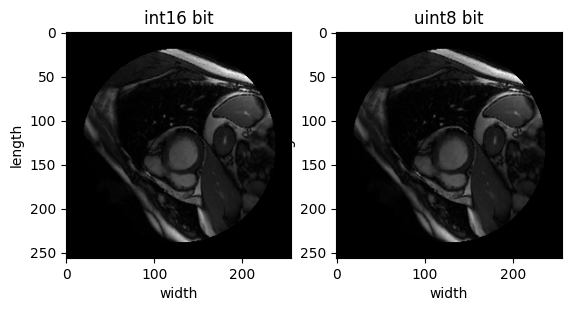

In [5]:
# read the dcm image
dicom_image = pydicom.dcmread(img_ex_filepath)

# extract the pixel data and convert to 8 bit image
image = img_as_ubyte (dicom_image.pixel_array / np.max(dicom_image.pixel_array))

fig, ax = plt.subplots(1,2)
ax[0].imshow(dicom_image.pixel_array, cmap="gray", vmin = np.min(dicom_image.pixel_array), vmax=np.max(dicom_image.pixel_array))
ax[0].set(title=f"{dicom_image.pixel_array.dtype} bit", xlabel='width', ylabel='length')

ax[1].imshow(image, cmap="gray", vmin=np.min(image), vmax=np.max(image))
ax[1].set(title=f"{image.dtype} bit", xlabel='width', ylabel='length')
plt.show()

Extract pixel spacing that might be needed later

In [6]:
# pixel spacing
pixel_spacing = dicom_image.PixelSpacing
slice_thickness = dicom_image.SliceThickness if 'SliceThickness' in dicom_image else 1

Filter out the noise from the image using gaussian or median filters

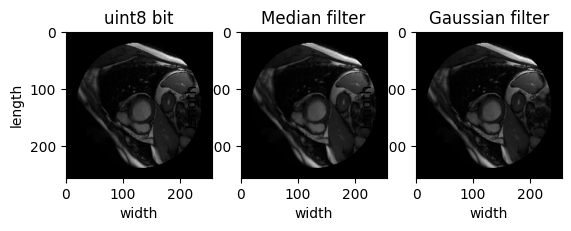

In [25]:
# denoise the image using median filter

disk_size = 1
sigma_val = 0.2
image_blurred_med = filters.median(image, morphology.disk(disk_size))

image_blurred_gaus = filters.gaussian(image, sigma=sigma_val)

fig, ax = plt.subplots(1,3)

ax[0].imshow(image, cmap="gray", vmin=np.min(image), vmax=np.max(image))
ax[0].set(title=f"{image.dtype} bit", xlabel='width', ylabel='length')

ax[1].imshow(image_blurred_med, cmap='gray', vmin=np.min(image_blurred_med), vmax=np.max(image_blurred_med))
ax[1].set(title=f"Median filter", xlabel='width', ylabel='length')

ax[2].imshow(image_blurred_gaus, cmap='gray', vmin=np.min(image_blurred_gaus), vmax=np.max(image_blurred_gaus))
ax[2].set(title=f"Gaussian filter", xlabel='width', ylabel='length')
plt.show()

Enhance contract using CLAHE (contrast limited adaptive histogram equalization)

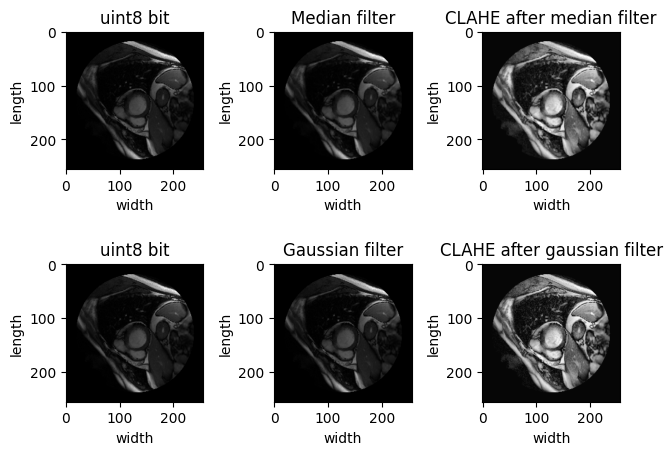

In [26]:
# apply clahe

clip_limit_val = 0.03
img_contrast_med = exposure.equalize_adapthist(image_blurred_med, clip_limit=clip_limit_val)

img_contrast_gaus = exposure.equalize_adapthist(image_blurred_gaus, clip_limit=clip_limit_val)


fig, ax = plt.subplots(2,3)

ax[0,0].imshow(image, cmap="gray", vmin=np.min(image), vmax=np.max(image))
ax[0,0].set(title=f"{image.dtype} bit", xlabel='width', ylabel='length')

ax[0,1].imshow(image_blurred_med, cmap='gray', vmin=np.min(image_blurred_med), vmax=np.max(image_blurred_med))
ax[0,1].set(title=f"Median filter", xlabel='width', ylabel='length')

ax[0,2].imshow(img_contrast_med, cmap='gray', vmin=np.min(img_contrast_med), vmax=np.max(img_contrast_med))
ax[0,2].set(title=f"CLAHE after median filter", xlabel='width', ylabel='length')



ax[1,0].imshow(image, cmap="gray", vmin=np.min(image), vmax=np.max(image))
ax[1,0].set(title=f"{image.dtype} bit", xlabel='width', ylabel='length')


ax[1,1].imshow(image_blurred_gaus, cmap='gray', vmin=np.min(image_blurred_gaus), vmax=np.max(image_blurred_gaus))
ax[1,1].set(title=f"Gaussian filter", xlabel='width', ylabel='length')

ax[1,2].imshow(img_contrast_gaus, cmap='gray', vmin=np.min(img_contrast_gaus), vmax=np.max(img_contrast_gaus))
ax[1,2].set(title=f"CLAHE after gaussian filter", xlabel='width', ylabel='length')

plt.tight_layout()
plt.show()

As we can see in the above results, both gaussian and median filters provide good results. I will continue with gaussian filtering.

Edge detection with Canny function

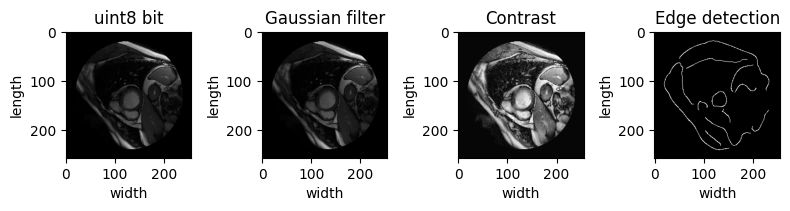

In [58]:
# apply canny to detect edges
sigma_val = 6.5
edges_gaus = canny(img_contrast_gaus, sigma= sigma_val)


fig, ax = plt.subplots(1,4, figsize=(8,8))

ax[0].imshow(image, cmap="gray", vmin=np.min(image), vmax=np.max(image))
ax[0].set(title=f"{image.dtype} bit", xlabel='width', ylabel='length')

ax[1].imshow(image_blurred_gaus, cmap='gray', vmin=np.min(image_blurred_gaus), vmax=np.max(image_blurred_gaus))
ax[1].set(title=f"Gaussian filter", xlabel='width', ylabel='length')

ax[2].imshow(img_contrast_gaus, cmap='gray', vmin=np.min(img_contrast_gaus), vmax=np.max(img_contrast_gaus))
ax[2].set(title=f"Contrast", xlabel='width', ylabel='length')

ax[3].imshow(edges_gaus, cmap='gray', vmin=np.min(edges_gaus), vmax=np.max(edges_gaus))
ax[3].set(title=f"Edge detection", xlabel='width', ylabel='length')

plt.tight_layout()
plt.show()

Find and draw the contours

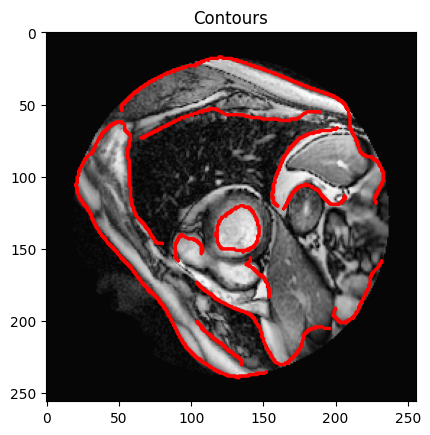

In [59]:
# find contours at a constant value
level_val = 0.8
contours = measure.find_contours(edges_gaus, level=level_val)

# Display the contours on the original image
fig, ax = plt.subplots()
ax.imshow(img_contrast_gaus, cmap='gray')
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], color='r', linewidth=2)  # Red contours
ax.set_title("Contours")
plt.show()

As we can see, the ventricle does get enclosed but there are a lot of other things as well. I will try to extract the circles in the edge detected image. 

Check if the contour is closed or not

In [69]:
def contour_is_closed(contour, tolerance=10.0):

    # check distance between the first and last poitns is small
    start_point = contour[0]
    end_point = contour[-1]
    distance = np.linalg.norm(start_point - end_point)
    print(distance)

    return distance < tolerance

closed_contours = [contour for contour in contours if contour_is_closed(contour)]

if closed_contours:
    largest_contour = max(closed_contours, key=lambda contour: len(contour))


    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], color='r', linewidth=2) 
    ax.set_title("Contours")
    plt.show()

else:
    print("No closed contours found.")

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
